In [262]:
import torch
import matplotlib.pyplot as plt

from video_jepa.data import VideoDataset
from video_jepa.world_model import WorldModel

In [263]:
video_encoder, _ = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_vit_large')

n_frames = 3
input_size = (384, 384)
patch_size = video_encoder.patch_size
model = WorldModel(
    num_hist=n_frames,
    num_pred=n_frames,
    video_encoder=video_encoder,
    input_size=input_size
)

# Load pretrained models
model.latent_predictor.load_state_dict(torch.load("output/latent_predictor.pt"))
model.decoder.load_state_dict(torch.load("output/decoder.pt"))
model.cuda()

# Predicting future frames
model.latent_predictor

ViT(
  (dropout): Dropout(p=0, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1024, out_features=2048, bias=True)
            (2): GELU(approximate='none')
            (3): Dropout(p=0.1, inplace=False)
            (4): Linear(in_features=2048, out_features=1024, bias=True)
         

In [293]:
# Initialize the training set to visualize next frame predictions
train_dataset = VideoDataset(
    "/dataB6/rob/movi_f2",
    seq_len=12,
    crop_size=input_size,
    max_frame_stride=5,
)

# Sample an index from the training set
batch = train_dataset[3]
x = batch["video"].unsqueeze(0).moveaxis(1, 2).cuda()

x.shape

torch.Size([1, 3, 12, 384, 384])

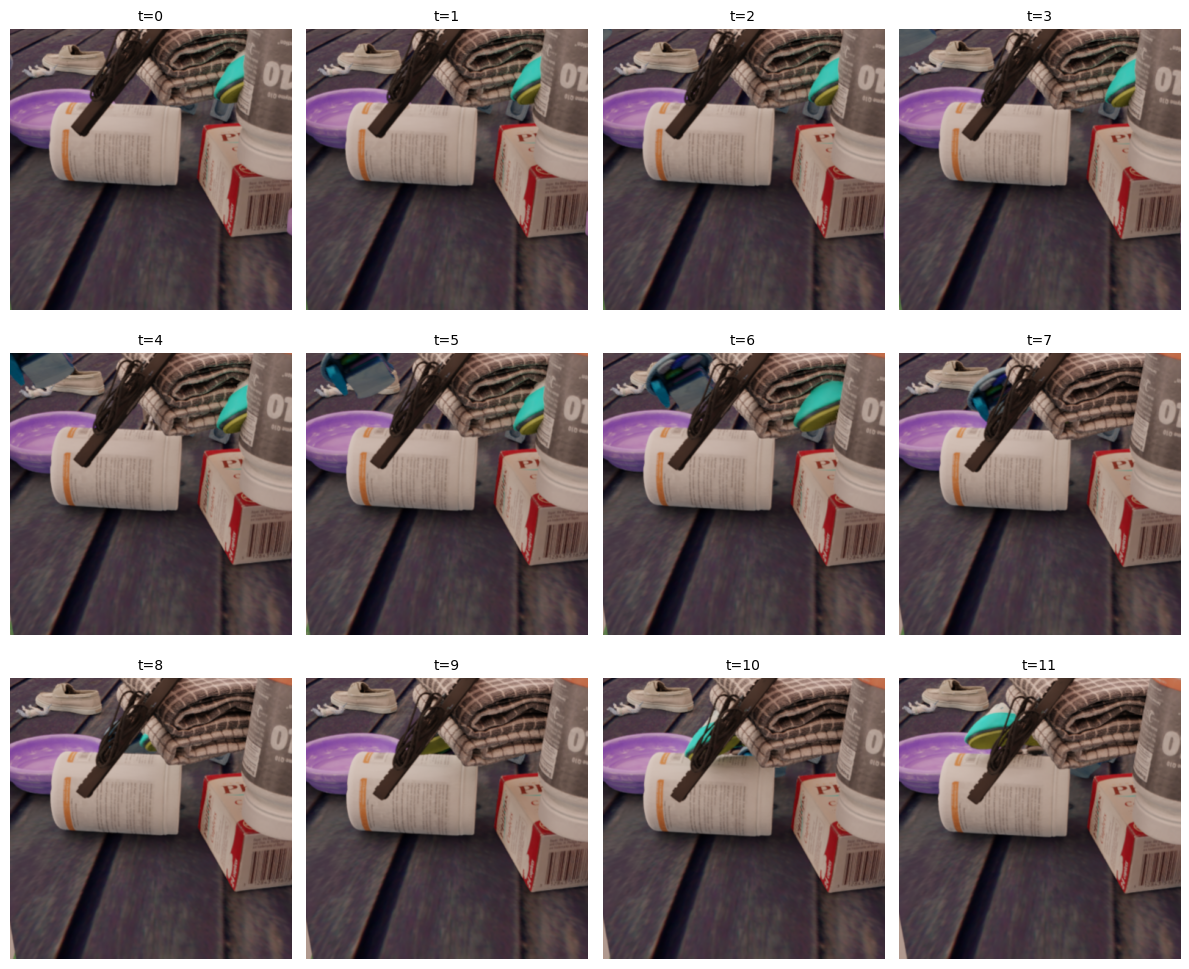

In [294]:
# The video looks as following
vid = x[0].cpu().permute(1, 0, 2, 3)  # (12, 3, H, W)
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(vid[i].moveaxis(0, -1).cpu().numpy())
    ax.set_title(f"t={i}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

This is the dataset on which the predictor and decoder are finetuned on. We feed the first 6 images, and let the model VQVAE model predict the next frames.

In [295]:
B, C, T, H, W = x.shape

patch_h = input_size[0] // patch_size 
patch_w = input_size[1] // patch_size

# Inputting the first 6 frames as context
with torch.no_grad():
    z = model.encoder(x[:, :, :6, ...])

patch_t = z.shape[1] // (patch_h * patch_w)
z = z.reshape(B, patch_t, -1, z.shape[-1])
z.shape

torch.Size([1, 3, 576, 1024])

In [296]:
# Latent Predictor inference, ViT
# (b * frames * num_patches, dim)
with torch.no_grad():
    z_pred = model.latent_predictor(z.reshape(B, -1, z.shape[-1]))
z_pred = z_pred.reshape(B, 3, patch_h * patch_w, video_encoder.embed_dim)
z_pred.shape

torch.Size([1, 3, 576, 1024])

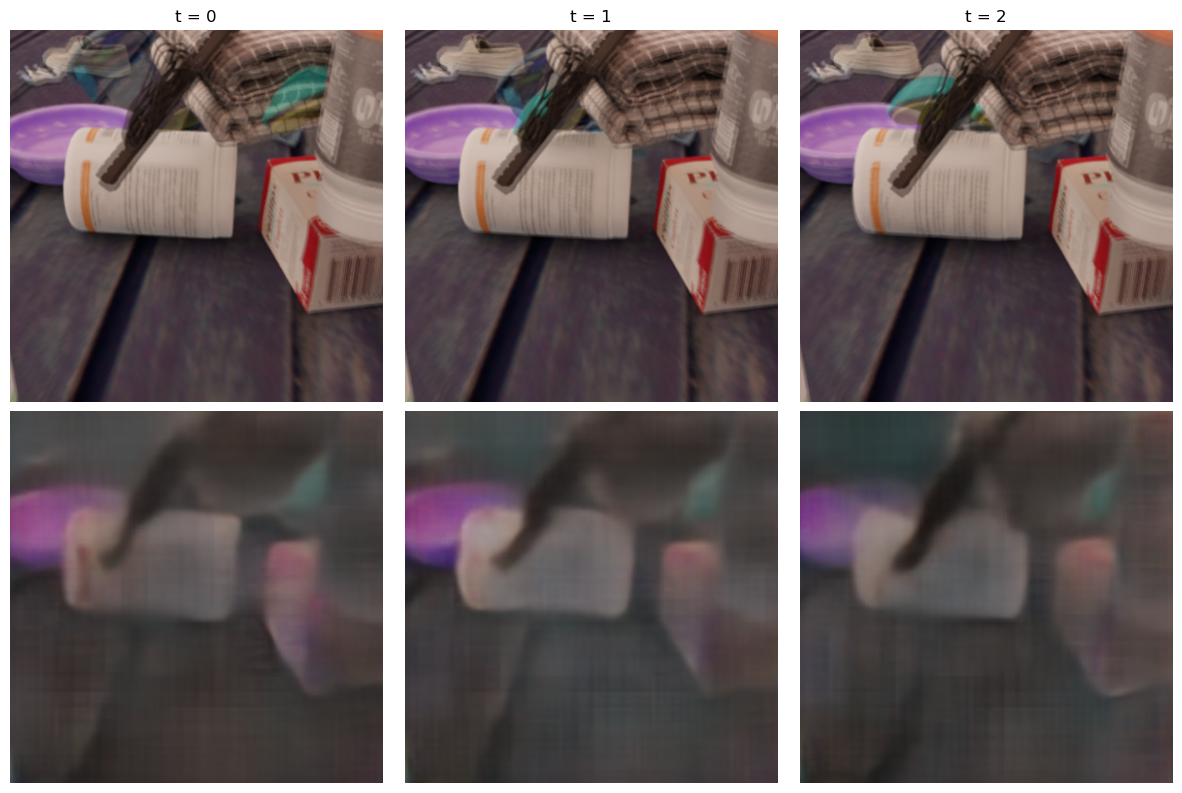

In [297]:
# Decoder, VQVAE to visualize the predictions
with torch.no_grad():
    visual_pred, diff_pred = model.decoder(
        z_pred,
        patch_h,
        patch_w
    )

# TODO: Currently the frames are still averaged as the VAE only outputs 
# a single frame per latent.

visual_tgt = x[:, :, 3 * 2 :, ...].moveaxis(1, 2)
# Reshape to (B, tubelet, num_pred, C, H, W) to average tubelet size
visual_tgt = visual_tgt.view(B, -1, 3, C, H, W).mean(dim=1)
visual_pred = visual_pred.view(B, 3, C, H, W)

k = 3
tgt_frames  = visual_tgt[0][-k:]
pred_frames = visual_pred[0][-k:]

T = visual_tgt[0].shape[0]  # total timesteps
times = range(T - k, T)

fig, axes = plt.subplots(2, k, figsize=(4*k, 8))

for i, (t, f) in enumerate(zip(times, tgt_frames)):
    axes[0, i].imshow(f.moveaxis(0, -1).detach().cpu().numpy())
    axes[0, i].set_title(f"t = {t}")
    axes[0, i].axis("off")

for i, (t, f) in enumerate(zip(times, pred_frames)):
    axes[1, i].imshow(f.moveaxis(0, -1).detach().cpu().numpy())
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

We can also compare the predicted latents of the source and the prediction model.

In [298]:
# Preparing everything for PCA
embed_dim = model.encoder.embed_dim
z_pred = z_pred.reshape(-1, embed_dim)

def pca(X, n_components=3):
    Z_mean = X.mean(0, keepdim=True)
    Z = X - Z_mean
    U, S, VT = torch.linalg.svd(Z, full_matrices=False)
    
    max_col = torch.argmax(torch.abs(U), dim=0)
    signs = torch.sign(U[max_col, range(U.shape[1])])
    VT *= signs[:, None]

    Z = torch.matmul(Z, VT[:n_components].T)
    return Z

def min_max(X, target_min = 0.0, target_max = 1.0):
    eps = 1e-8
    X_std = (X - X.min(0, True).values) / (X.max(0, True).values - X.min(0, True).values + eps)
    X_scaled = X_std * (target_max - target_min) + target_min
    return X_scaled

z_pred = min_max(pca(z_pred))
z_pred.shape

torch.Size([1728, 3])

In [299]:
with torch.no_grad():
    z_target = model.encoder(x)

patch_t = z_target.shape[1] // (patch_h * patch_w)
z_target = z_target.reshape(B, patch_t, -1, embed_dim)

z_target = z_target[:, 3:].reshape(-1, embed_dim)
z_target = min_max(pca(z_target))
z_target.shape

torch.Size([1728, 3])

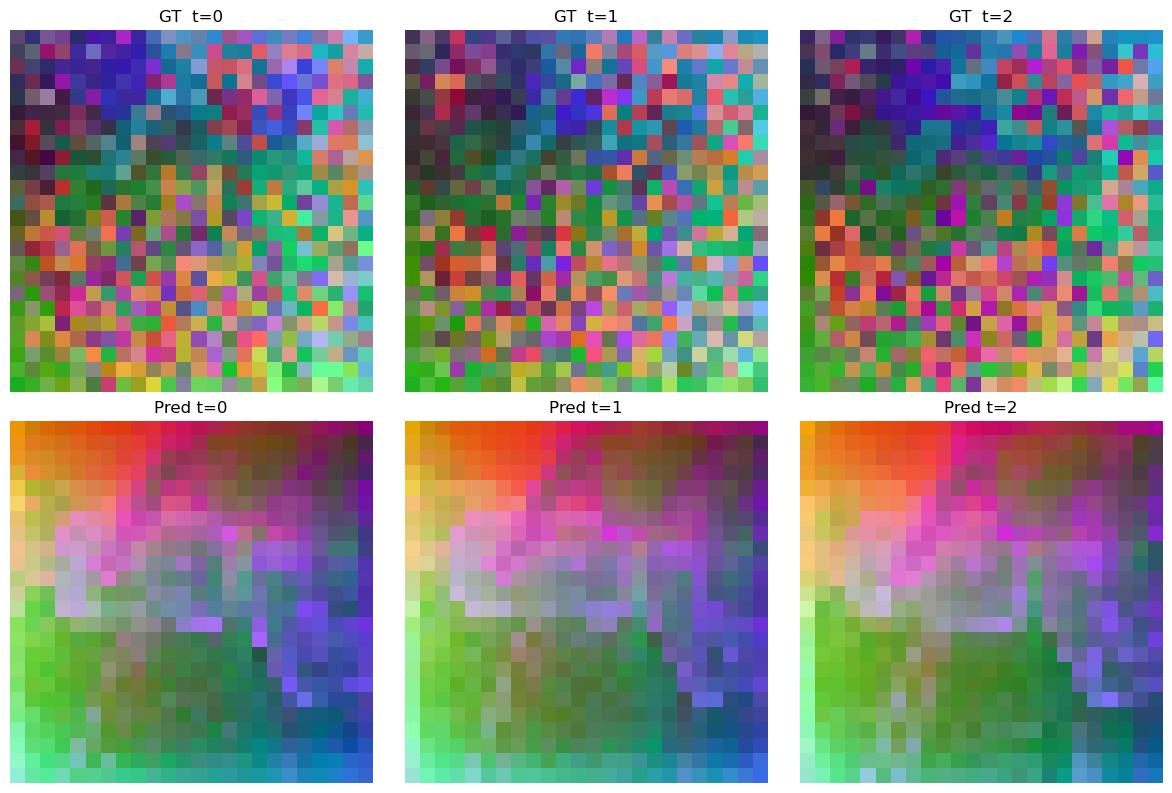

In [300]:
pred = z_pred.reshape(3, patch_h, patch_w, 3)
gt = z_target.reshape(3, patch_h, patch_w, 3)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for t in range(3):
    axes[0, t].imshow(gt[t].cpu())
    axes[0, t].set_title(f"GT  t={t}")
    axes[0, t].axis("off")

    axes[1, t].imshow(pred[t].cpu())
    axes[1, t].set_title(f"Pred t={t}")
    axes[1, t].axis("off")

plt.tight_layout()
plt.show()